## Deep Learning Model Development for Multiclass Prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf

!pip install nltk

import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /Users/ladan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ladan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ladan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Load the data file into a Pandas Dataframe
claim_data = pd.read_csv("PartII_Data/ClaimData.csv")

#Explore the data loaded
print(claim_data.dtypes)
claim_data.head()

ClaimId              int64
LineItemID           int64
PetPolicyID          int64
ItemDescription     object
DiagnosisOne        object
DiagnosisTwo        object
LineItemPrice      float64
ClaimDateClosed     object
Condition           object
dtype: object


,ClaimId,LineItemID,PetPolicyID,ItemDescription,DiagnosisOne,DiagnosisTwo,LineItemPrice,ClaimDateClosed,Condition
0,16980751,2073120,0,Freyja: Boarding (Canine 51-75 Lbs),Anal Gland Surgery,NaN,25.00,2019-10-02 15:33:00.0000000,NO COND
1,17856529,3193005,1,Axel: Biohazard Fee,Atopy,NaN,3.49,2020-06-29 14:28:00.0000000,ALLERGY (ALLERGIC)
2,17075791,392218,3,Kallie: Sedation (DexDomitor),ruptured CCL (right),NaN,142.22,2019-11-01 19:29:00.0000000,"CRUCIATE RUPTURE (ACL, CCL)"
3,16890631,977795,4,Kaiden: Scaling (Canine),Dental,NaN,84.25,2019-09-05 13:57:00.0000000,DENTAL DISEASE
4,17152945,1907072,5,Sadie Mae: Pain Management Level 2,TPLO,NaN,67.60,2019-11-26 07:43:00.0000000,"CRUCIATE RUPTURE (ACL, CCL)"


In [3]:
claim_data['Condition'].value_counts()

NO COND                                                                39715
ALLERGY (ALLERGIC)                                                      8175
MASS(ES)                                                                6487
DIARRHEA                                                                6011
VOMITING                                                                5396
OTITIS EXTERNA                                                          4734
LIMPING                                                                 4220
DENTAL DISEASE                                                          3067
GASTROENTERITIS                                                         2695
CRUCIATE RUPTURE (ACL, CCL)                                             2551
FRACTURE                                                                2433
URINARY TRACT INFECTION                                                 2076
KIDNEY DISEASE                                                          1634

In [4]:
print('The number of classes in the target column is:', claim_data['Condition'].value_counts().count())

The number of classes in the target column is: 21


In [5]:
claim_data['combined_text']=claim_data['ItemDescription']+' '+claim_data['DiagnosisOne']

In [6]:
#Separate feature and target data
claim_classes_raw = claim_data["Condition"]
claim_messages = claim_data["combined_text"]

In [7]:
claim_data["combined_text"].isna().sum()

9

In [8]:
claim_data['combined_text'] = claim_data['combined_text'].fillna('No Data')

### Creating text representation

In [9]:
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split

#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(claim_messages)
#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
claim_classes = label_encoder.fit_transform(
                                claim_classes_raw)

#Convert target to one-hot encoding vector
claim_classes = tf.keras.utils.to_categorical(claim_classes,21)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", claim_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, claim_classes, test_size=0.10)

TF-IDF Matrix Shape :  (98057, 42435)
One-hot Encoding Shape :  (98057, 21)


### Building and evaluating the model

In [10]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

#Setup Hyper Parameters for building the model
NB_CLASSES=21
N_HIDDEN=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-Layer-1 (Dense)       (None, 32)                1357952   
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 32)                1056      
_________________________________________________________________
Output-Layer (Dense)         (None, 21)                693       
Total params: 1,359,701
Trainable params: 1,359,701
Non-trainable params: 0
_________________________________________________________________



Training Progress:
------------------------------------
Epoch 1/10
276/276 [==============================] - 30s 103ms/step - loss: 2.3429 - accuracy: 0.4201 - val_loss: 1.2669 - val_accuracy: 0.6548
Epoch 2/10
276/276 [==============================] - 17s 63ms/step - loss: 1.0636 - accuracy: 0.7193 - val_loss: 0.7517 - val_accuracy: 0.8060
Epoch 3/10
276/276 [==============================] - 17s 60ms/step - loss: 0.6236 - accuracy: 0.8411 - val_loss: 0.6159 - val_accuracy: 0.8291
Epoch 4/10
276/276 [==============================] - 17s 62ms/step - loss: 0.4908 - accuracy: 0.8655 - val_loss: 0.5767 - val_accuracy: 0.8358
Epoch 5/10
276/276 [==============================] - 18s 65ms/step - loss: 0.4286 - accuracy: 0.8789 - val_loss: 0.5623 - val_accuracy: 0.8409
Epoch 6/10
276/276 [==============================] - 16s 60ms/step - loss: 0.3824 - accuracy: 0.8911 - val_loss: 0.5583 - val_accuracy: 0.8420
Epoch 7/10
276/276 [==============================] - 18s 65ms/step - loss: 0.

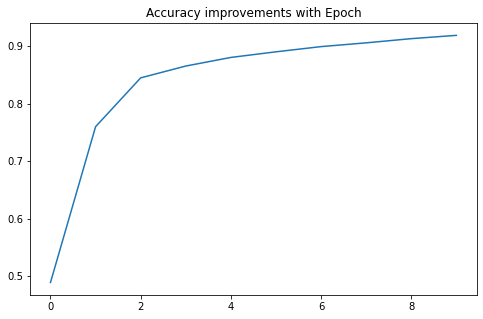


Evaluation against Test Dataset :
------------------------------------
307/307 [==============================] - 2s 5ms/step - loss: 0.5534 - accuracy: 0.8447


[0.5533573031425476, 0.8446869254112244]

In [11]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

### Predicting for text

In [12]:
holdout_data = pd.read_csv('PartII_Data/Holdout.csv')

In [13]:
holdout_data['combined_text']=holdout_data['ItemDescription']+' '+holdout_data['DiagnosisOne']

In [14]:
holdout_data['combined_text'] = holdout_data['combined_text'].fillna('No Data')

In [15]:
holdout_messages = holdout_data["combined_text"]

In [16]:
holdout_messages.isna().sum()

0

In [17]:
#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(holdout_messages).toarray()

In [18]:
print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(5000, 42435)
Prediction Output: [15 15  4 ... 15 15 20]
Prediction Classes are  ['NO COND' 'NO COND' 'DIARRHEA' ... 'NO COND' 'NO COND' 'VOMITING']
